### Automatic Ticket Classification Case Study - NLP

For a financial company, customer complaints carry a lot of importance, as they are often an indicator of the shortcomings in their products and services. If these complaints are resolved efficiently in time, they can bring down customer dissatisfaction to a minimum and retain them with stronger loyalty. This also gives them an idea of how to continuously improve their services to attract more customers.
These customer complaints are unstructured text data; so, traditionally, companies need to allocate the task of evaluating and assigning each ticket to the relevant department to multiple support employees. This becomes tedious as the company grows and has a large customer base.
In this case study, you will be working as an NLP engineer for a financial company that wants to automate its customer support tickets system. As a financial company, the firm has many products and services such as credit cards, banking and mortgages/loans.

#### Business Goal

We need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.
You will be doing topic modelling on the .json data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

 -  Credit card / Prepaid card
 -  Bank account services
 -  Theft/Dispute reporting
 -  Mortgages/loans
 -  Others

With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

#### Pipelines that needs to be performed:
You need to perform the following eight major tasks to complete the assignment:

1. Data loading
2. Text preprocessing
3. Exploratory data analysis (EDA)
4. Feature extraction
5. Topic modelling

#### Import Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as sns
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag_sents
from nltk.tokenize import wordpunct_tokenize
from pprint import pprint
import re, random, os
import string
# spacy for basic preprocessing, optional, can use nltk as well (lemmatisation etc.)
import spacy

# gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import json
from wordcloud import WordCloud

### 1. Data Loading

In [2]:
json_data = open('complaints-2021-05-14_08_16.json')
data = json.load(json_data)
df=pd.json_normalize(data)

In [3]:
df.head(5)

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
df.shape #78313 rows , 22 cols

(78313, 22)

In [5]:
df.dtypes

_index                                object
_type                                 object
_id                                   object
_score                               float64
_source.tags                          object
_source.zip_code                      object
_source.complaint_id                  object
_source.issue                         object
_source.date_received                 object
_source.state                         object
_source.consumer_disputed             object
_source.product                       object
_source.company_response              object
_source.company                       object
_source.submitted_via                 object
_source.date_sent_to_company          object
_source.company_public_response       object
_source.sub_product                   object
_source.timely                        object
_source.complaint_what_happened       object
_source.sub_issue                     object
_source.consumer_consent_provided     object
dtype: obj

#### 1.1 Data Pre-Processing

In [6]:
# checking the columns
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

#### Missing Value Analysis 

In [8]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

##### Inference: Missing values

 1. _source.tags = 67413
 2. _source.zip_code = 6757
 3. _source.state = 1991
 4. _source.company_public_response = 78309
 5. _source.sub_product = 10571
 6. _source.sub_issue = 46297
 7. _source.consumer_consent_provided = 1008

In [9]:
# Missing value percentage
missing_percentage = df.isnull().mean() * 100
print(round(missing_percentage),2)

_index                                 0.0
_type                                  0.0
_id                                    0.0
_score                                 0.0
_source.tags                          86.0
_source.zip_code                       9.0
_source.complaint_id                   0.0
_source.issue                          0.0
_source.date_received                  0.0
_source.state                          3.0
_source.consumer_disputed              0.0
_source.product                        0.0
_source.company_response               0.0
_source.company                        0.0
_source.submitted_via                  0.0
_source.date_sent_to_company           0.0
_source.company_public_response      100.0
_source.sub_product                   13.0
_source.timely                         0.0
_source.complaint_what_happened        0.0
_source.sub_issue                     59.0
_source.consumer_consent_provided      1.0
dtype: float64 2


In [10]:
# Converting '_source.complaint_what_happened' blank rows into NaN values
df['_source.complaint_what_happened'].replace("", np.nan, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_24744\2309442357.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['_source.complaint_what_happened'].replace("", np.nan, inplace=True)


In [11]:
 round(df.isna().mean() * 100,2)

_index                                0.00
_type                                 0.00
_id                                   0.00
_score                                0.00
_source.tags                         86.08
_source.zip_code                      8.63
_source.complaint_id                  0.00
_source.issue                         0.00
_source.date_received                 0.00
_source.state                         2.54
_source.consumer_disputed             0.00
_source.product                       0.00
_source.company_response              0.00
_source.company                       0.00
_source.submitted_via                 0.00
_source.date_sent_to_company          0.00
_source.company_public_response      99.99
_source.sub_product                  13.50
_source.timely                        0.00
_source.complaint_what_happened      73.09
_source.sub_issue                    59.12
_source.consumer_consent_provided     1.29
dtype: float64

In [12]:
#Dropping NaN rows from "_source.complaint_what_happened" as it as 73.09% Null values
df.dropna(subset=['_source.complaint_what_happened'], inplace=True)


In [13]:
df.shape 
# 21072 rows, 22 cols

(21072, 22)

#### Removing unwanted characters and re-naming the columns

In [14]:
df.columns = [re.sub('^_', '', col) for col in df.columns]

# Remove "source." from column names
df.columns = [re.sub(r"^source\.", "", col) for col in df.columns]



In [15]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [16]:
df.head(3)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,Chase Card was reported on XX/XX/2019. However...,Information belongs to someone else,Consent provided


### 2. Text Pre-processing

In [17]:
def clean_texts(text):
    
    text = text.lower()
    
    
    text = re.sub(r'\[.*?\]', '', text)
    
 
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    
   
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [18]:
#Cleaning df['complaint_what_happened']
df['complaint_what_happened']= df['complaint_what_happened'].apply(lambda x: clean_texts(x))

In [19]:
!python -m spacy download en_core_web_sm


     --------------------------------------- 12.8/12.8 MB 18.2 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
# Lemmatize the texts
def lemma_texts(text):     
        

    lemma_list = []
    
    
    document = nlp(text)
    for word in document:
        lemma_list.append(word.lemma_)
        
   
    return " ".join(lemma_list)

In [24]:
# Add a column for lemmatized complaints to the dataframe
df["lemmatized_complaint"] =  df.apply(lambda x: lemma_texts(x['complaint_what_happened']), axis=1)




In [25]:
df.head(5)

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint_what_happened,sub_issue,consumer_consent_provided,lemmatized_complaint
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,good morning my name is xxxx xxxx and i apprec...,Didn't receive enough information to verify debt,Consent provided,good morning my name be xxxx xxxx and I apprec...
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,i upgraded my xxxx xxxx card in and was told ...,Problem with rewards from credit card,Consent provided,I upgrade my xxxx xxxx card in and be tell b...
10,complaint-public-v2,complaint,3233499,0.0,None,104XX,3233499,Incorrect information on your report,2019-05-06T12:00:00-05:00,NY,...,JPMORGAN CHASE & CO.,Web,2019-05-06T12:00:00-05:00,None,Other personal consumer report,Yes,chase card was reported on however fraudulent...,Information belongs to someone else,Consent provided,chase card be report on however fraudulent a...
11,complaint-public-v2,complaint,3180294,0.0,None,750XX,3180294,Incorrect information on your report,2019-03-14T12:00:00-05:00,TX,...,JPMORGAN CHASE & CO.,Web,2019-03-15T12:00:00-05:00,None,Credit reporting,Yes,on while trying to book a xxxx xxxx ticket ...,Information belongs to someone else,Consent provided,on while try to book a xxxx xxxx ticket ...
14,complaint-public-v2,complaint,3224980,0.0,None,920XX,3224980,Managing an account,2019-04-27T12:00:00-05:00,CA,...,JPMORGAN CHASE & CO.,Web,2019-04-27T12:00:00-05:00,None,Checking account,Yes,my grand son give me check for i deposit it i...,Funds not handled or disbursed as instructed,Consent provided,my grand son give I check for I deposit it i...


In [26]:
df.shape #21072 rows and 23 cols after the addition of new column 'lemmatized_complaint'.

(21072, 23)

In [27]:
# New dataframe

df_cleaned_data=df[['complaint_what_happened','lemmatized_complaint']]

In [28]:
df_cleaned_data.head(5)

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...


#### Extracting Singular Nouns

In [29]:
from textblob import TextBlob
def singular_nouns(text):
   
    
    
    text_blob = TextBlob(text)
    
 
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

In [32]:
# Applying the function to create a new column containing only singular nouns 
df_cleaned_data["complaints_POS_removed"] =  df_cleaned_data.apply(lambda x: singular_nouns(x['lemmatized_complaint']), axis=1)


C:\Users\HP\AppData\Local\Temp\ipykernel_24744\2265279474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_data["complaints_POS_removed"] =  df_cleaned_data.apply(lambda x: singular_nouns(x['lemmatized_complaint']), axis=1)


In [33]:
df_cleaned_data.head(5)

,complaint_what_happened,lemmatized_complaint,complaints_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book xxxx ticket offer ticket card informa...
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...


### 3. Exploratory Data Analysis


##### 3.1 Visualize the data according to the 'Complaint' character length using Histogram

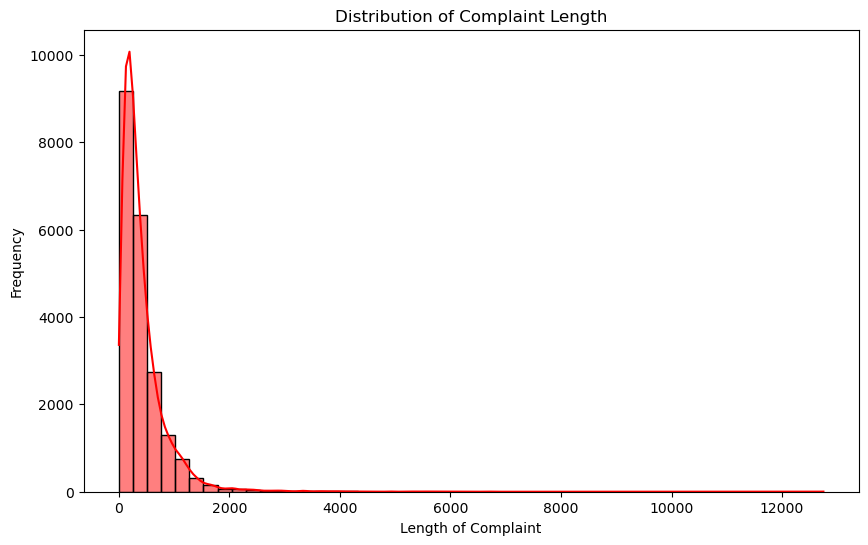

In [43]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned_data['complaints_POS_removed'].apply(len), bins=50, kde=True, color='red')
plt.title('Distribution of Complaint Length')
plt.xlabel('Length of Complaint')
plt.ylabel('Frequency')
plt.show()

##### 3.2 Word Cloud to find the top 40 words 

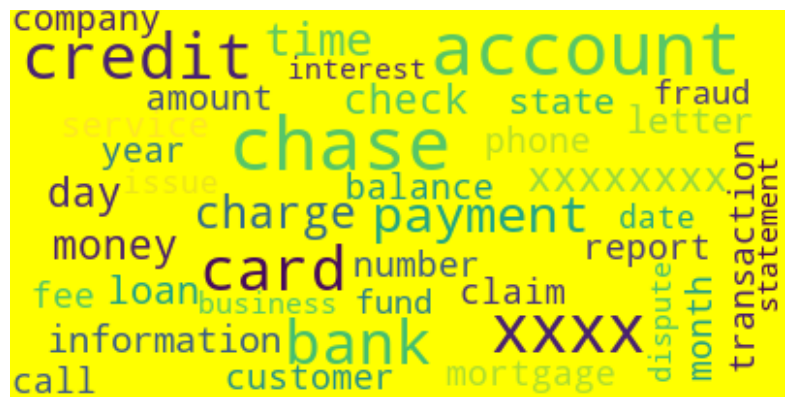

In [53]:
all_text = ' '.join(df_cleaned_data['complaints_POS_removed'].apply(clean_texts))


tokens = all_text.split()


word_freq = Counter(tokens)

top_40_words = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True)[:40])


wordcloud = WordCloud(background_color='yellow', max_font_size=38, random_state=42)
wordcloud.generate_from_frequencies(top_40_words)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


##### 3.3 Top 10 Unigrams by frequency among all the complaints after processing the text. 

In [54]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_unigrams(text, n=30):
    vectorizer = CountVectorizer(stop_words='english')
    bag_of_words = vectorizer.fit_transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)
    return word_freq[:n] 


In [55]:
# Get top unigrams
top_unigrams = get_top_unigrams(df_cleaned_data['complaints_POS_removed'].values.astype('U'))
df_unigrams = pd.DataFrame(top_unigrams, columns=['unigram', 'count'])

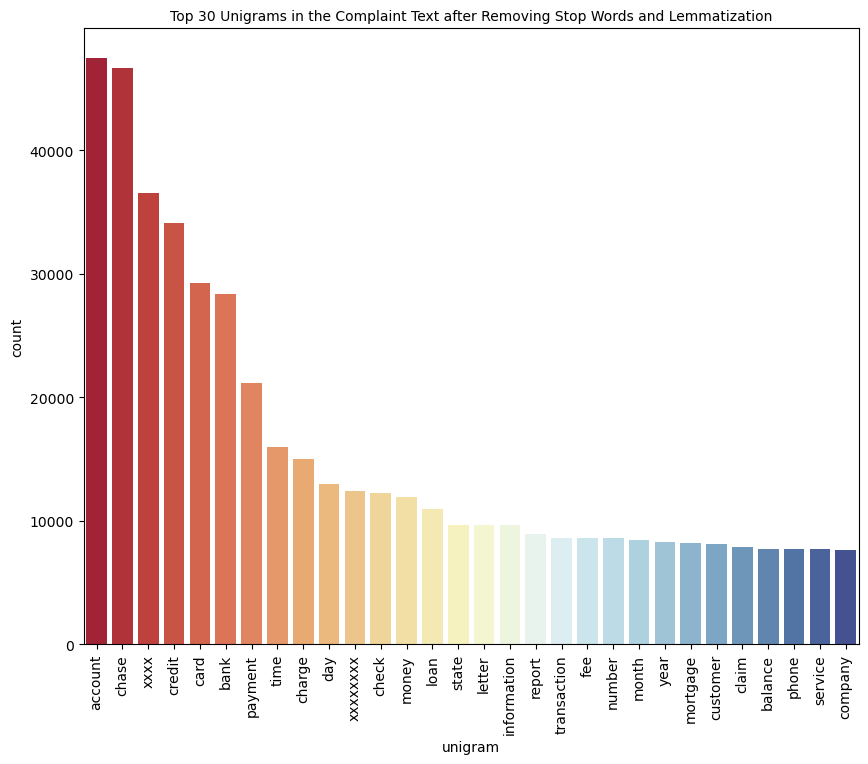

In [63]:
# Plot the top 30 unigrams
plt.figure(figsize=(10, 8))
sns.barplot(x='unigram', y='count', data=df_unigrams, palette="RdYlBu")
plt.xticks(rotation=90)
plt.title("Top 30 Unigrams in the Complaint Text after Removing Stop Words and Lemmatization", fontsize=10) 
plt.show()

##### 3.4 Top 10 Bigrams

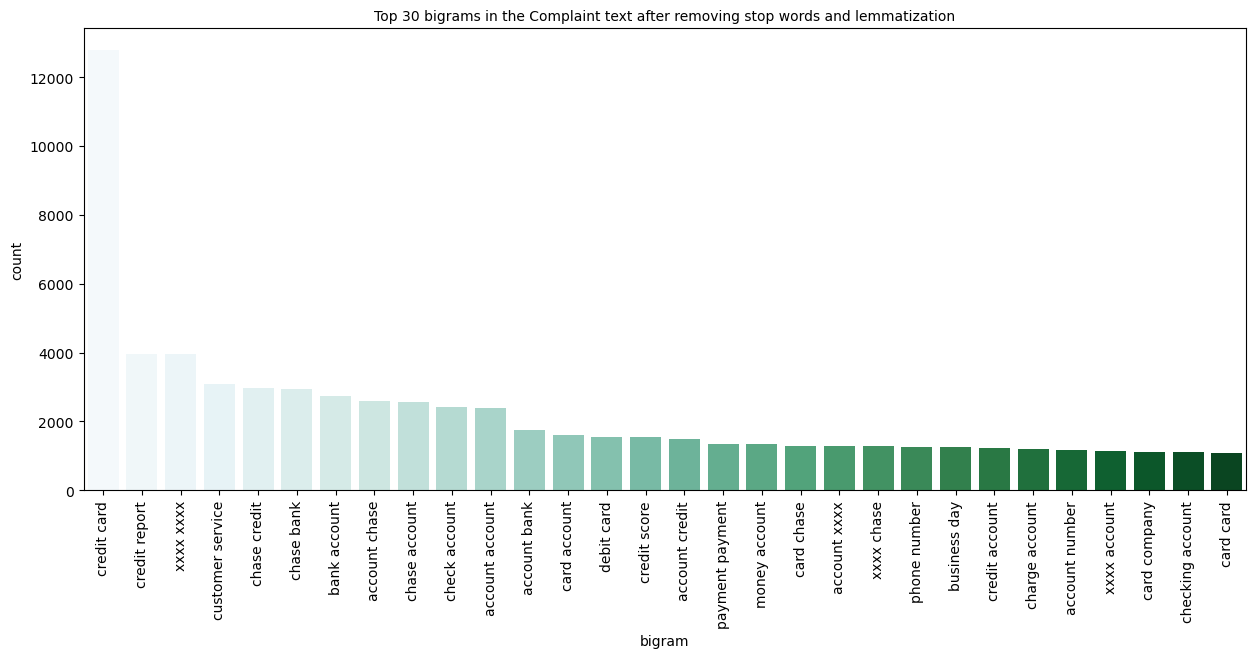

In [65]:
def get_top_bigram(text, n=30):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

top_common_bigrams = get_top_bigram(df_cleaned_data['complaints_POS_removed'].values.astype('U'))
df_bigram = pd.DataFrame(top_common_bigrams, columns = ['bigram' , 'count'])

plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="BuGn")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the Complaint text after removing stop words and lemmatization", fontsize=10) 
plt.show()

##### 3.4 Top 10 Trigrams

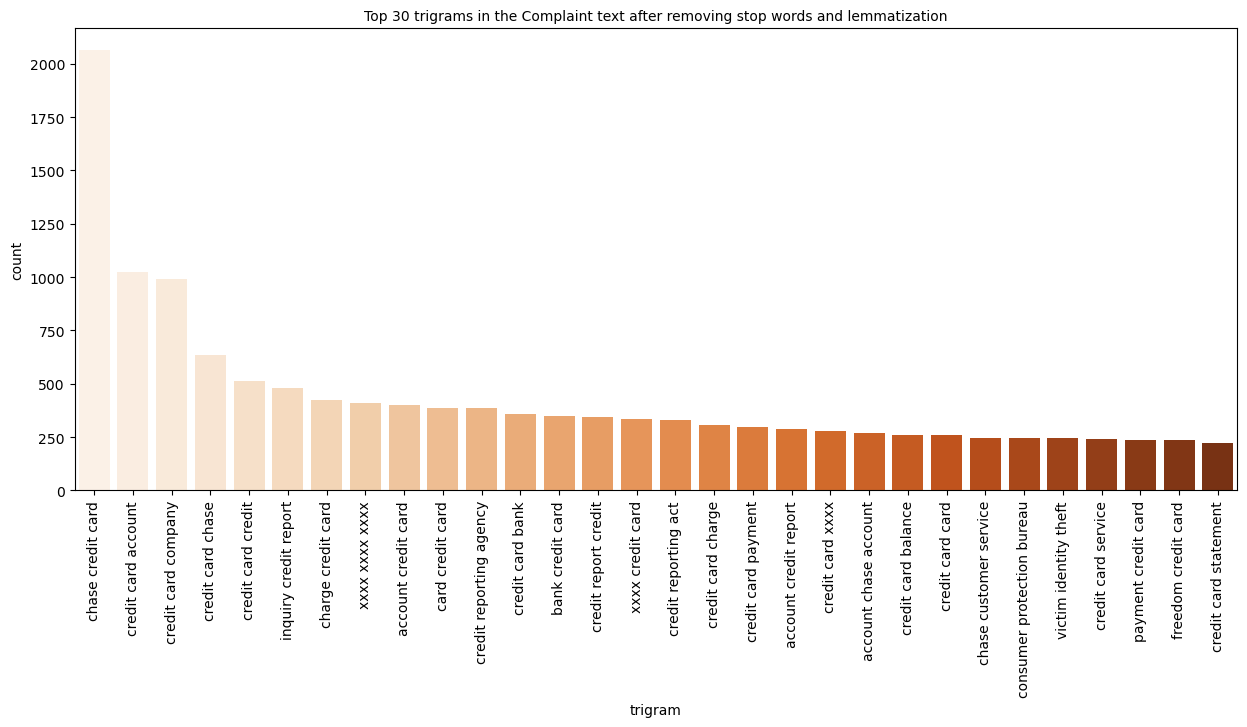

In [67]:
def get_top_trigram(text, n=30):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(text)
    bag_of_words = vector.transform(text)
    sum_of_words = bag_of_words.sum(axis=0) 
    word_freq = [(word, sum_of_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    word_freq =sorted(word_freq, key = lambda x: x[1], reverse=True)
    return word_freq[:n]

top_common_trigrams = get_top_trigram(df_cleaned_data['complaints_POS_removed'].values.astype('U'))
df_trigram = pd.DataFrame(top_common_trigrams, columns = ['trigram' , 'count'])

plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="Oranges")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the Complaint text after removing stop words and lemmatization", fontsize=10) 
plt.show()


Before moving into Feature extraction, we need to clean the data further. 

- The personal data of customer has been masked as XXXX and hence it has to be removed

In [70]:

df_cleaned_data.loc[:, 'complaints_POS_removed'] = df_cleaned_data['complaints_POS_removed'].str.replace('xxxx', '')


### 4. Feature Extraction

In [85]:
tfidf=TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')
dtm=tfidf.fit_transform(df_cleaned_data['complaints_POS_removed'])

### 5. Topic Modelling using NMF - Non-Negative Matrix Factorization

In [88]:
#Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_cleaned_data['complaints_POS_removed']
data_set = [x.split() for x in texts]


dictionary = Dictionary(data_set)


dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)


corpus = [dictionary.doc2bow(text) for text in data_set]

topic_num = list(np.arange(5, 10, 1))

coherence_scores = []

for num in topic_num:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=40
    )
    
  
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 5))


scores = list(zip(topic_num, coherence_scores))
best_topics_num = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_topics_num)

C:\Users\HP\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
C:\Users\HP\anaconda3\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


5


In [89]:
df_cleaned_data.shape

(21072, 3)

In [93]:
# Initialize NMF model with 5 components
nmf_model = NMF(n_components=5, random_state=40)

# Fit NMF model to the TF-IDF matrix
nmf_model.fit(dtm)


NMF(n_components=5, random_state=40)

In [101]:
# Get the feature names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()


for i, topic in enumerate(nmf_model.components_):
    top_word_index = topic.argsort()[-15:]
    print(f"Top words for Topic {i}:")
    for index in top_word_index:
        print(feature_names[index])
    print()


Top words for Topic 0:
customer
transfer
claim
transaction
business
number
day
branch
deposit
chase
fund
money
check
bank
account

Top words for Topic 1:
balance
year
letter
application
debt
information
limit
company
score
account
chase
inquiry
report
card
credit

Top words for Topic 2:
mortgage
year
chase
account
credit
pay
date
auto
time
day
statement
fee
month
balance
payment

Top words for Topic 3:
company
refund
statement
time
service
purchase
claim
fraud
merchant
chase
dispute
transaction
fee
card
charge

Top words for Topic 4:
sale
foreclosure
house
bank
document
time
rate
letter
year
property
chase
modification
home
mortgage
loan



In [102]:


topic_result = nmf_model.transform(dtm)
topic_result[0].round(2)
topic_result[0].argmax()
topic_result.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2], dtype=int64)

In [106]:

df_cleaned_data['Topic'] = topic_result.argmax(axis=1)

C:\Users\HP\AppData\Local\Temp\ipykernel_24744\2912875831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_data['Topic'] = topic_result.argmax(axis=1)


In [104]:
df_cleaned_data.shape

(21072, 4)

In [105]:
df_cleaned_data.head()

,complaint_what_happened,lemmatized_complaint,complaints_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,0
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,1
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,1
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,1
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,0


In [108]:
df_cleaned_data.replace({'Topic':{0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}},inplace=True)



C:\Users\HP\AppData\Local\Temp\ipykernel_24744\280947549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned_data.replace({'Topic':{0:"Bank Account services",


In [109]:
df_cleaned_data.head()

,complaint_what_happened,lemmatized_complaint,complaints_POS_removed,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember service ask ...,Bank Account services
2,i upgraded my xxxx xxxx card in and was told ...,I upgrade my xxxx xxxx card in and be tell b...,card agent upgrade date agent information orde...,Credit card or prepaid card
10,chase card was reported on however fraudulent...,chase card be report on however fraudulent a...,card report application identity consent servi...,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket ...,on while try to book a xxxx xxxx ticket ...,try book ticket offer ticket card information...,Credit card or prepaid card
14,my grand son give me check for i deposit it i...,my grand son give I check for I deposit it i...,son chase account fund bank account pay money ...,Bank Account services


### 6. Model Building

In [114]:
df_cleaned_data.loc[:, 'Topic'] = df_cleaned_data['Topic'].replace({
    "Bank Account services": 0,
    "Credit card or prepaid card": 1,
    "Others": 2,
    "Theft/Dispute Reporting": 3,
    "Mortgage/Loan": 4
})


In [115]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_cleaned_data[['complaint_what_happened','Topic']]

In [116]:
training_data.shape

(21072, 2)

In [118]:
# View value counts of the five topics
training_data['Topic'].value_counts()

Topic
0    5178
1    5004
3    4820
4    3809
2    2261
Name: count, dtype: int64

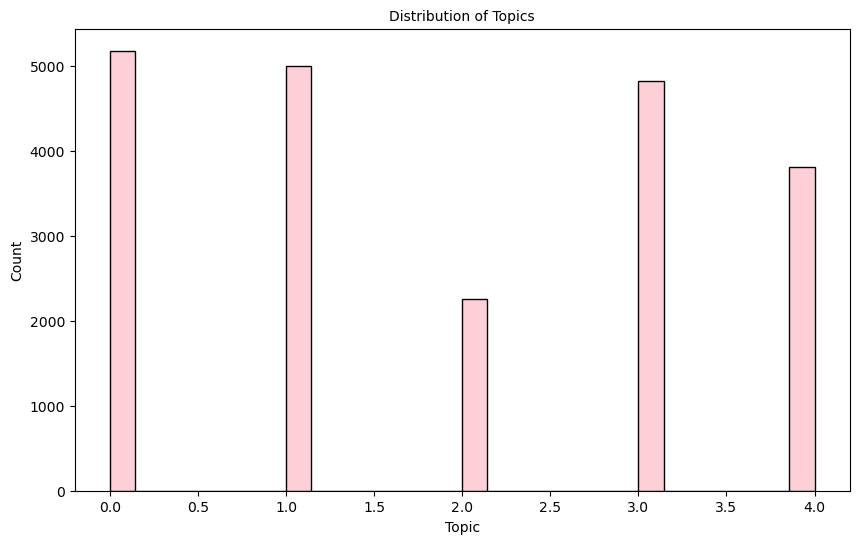

In [121]:
# Plotting a histogram of topics
plt.figure(figsize=[10,6])
sns.histplot(data=training_data, x='Topic',color='pink', )
plt.title("Distribution of Topics", fontsize=10)
plt.show()

In [122]:


count_vector=CountVectorizer()


X_train_count=count_vector.fit_transform(training_data['complaint_what_happened'])

In [123]:
# Saving Word Vector on disk for later usage
import pickle

pickle.dump(count_vector.vocabulary_, open("count_vector.pkl","wb"))

In [125]:
# Transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transform= TfidfTransformer()
X_train_tfidf = tfidf_transform.fit_transform(X_train_count)

In [126]:
# Save TF-IDF on disk for later usage
pickle.dump(tfidf_transform, open("tfidf.pkl","wb"))

In [128]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train Shape: {X_train.shape}")
print(f"y_train Shape: {y_train.shape}")
print(f"X_test Shape: {X_test.shape}")
print(f"y_test Shape: {y_test.shape}")

X_train Shape: (15804, 33599)
y_train Shape: (15804,)
X_test Shape: (5268, 33599)
y_test Shape: (5268,)


In [129]:
# Create a function to evaluate models
def model_eval(y_test, y_pred, model_name):
    

    print(f"CLASSIFICATION REPORT for {model_name}\n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
   
    plt.figure(figsize=(10,7))
    plt.title(f"CONFUSION MATRIX for {model_name}\n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Greens", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

##### 6.1 Logistic Regression

In [133]:
from sklearn.linear_model import LogisticRegression

model_name = 'LOGISTIC REGRESSION'
lr = LogisticRegression(max_iter=1000) 
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


In [134]:

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Hyperparameter tuning for best result
param_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001,0.01,0.1,1,10,100],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_lr = GridSearchCV(estimator=lr, 
                       param_grid=param_lr,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_lr.fit(X_train, y_train)
print(grid_lr.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:

{'C': 1, 'penalty': 'l1', 'solver': 'saga'}


In [135]:
# Creating model with best hyperparameter
lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')

lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = lr_tuned.predict(X_test)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [136]:
# Calculate F1 Score of tuned model using weighted average method
f1_lr = f1_score(y_test, y_pred_lr_tuned, average="weighted")
f1_lr

0.9437271296913512

CLASSIFICATION REPORT for LOGISTIC REGRESSION

                             precision    recall  f1-score   support

      Bank Account services       0.94      0.96      0.95      1304
Credit card or prepaid card       0.95      0.96      0.95      1280
                     Others       0.93      0.95      0.94       557
    Theft/Dispute Reporting       0.94      0.91      0.93      1213
              Mortgage/Loan       0.94      0.95      0.94       914

                   accuracy                           0.94      5268
                  macro avg       0.94      0.94      0.94      5268
               weighted avg       0.94      0.94      0.94      5268



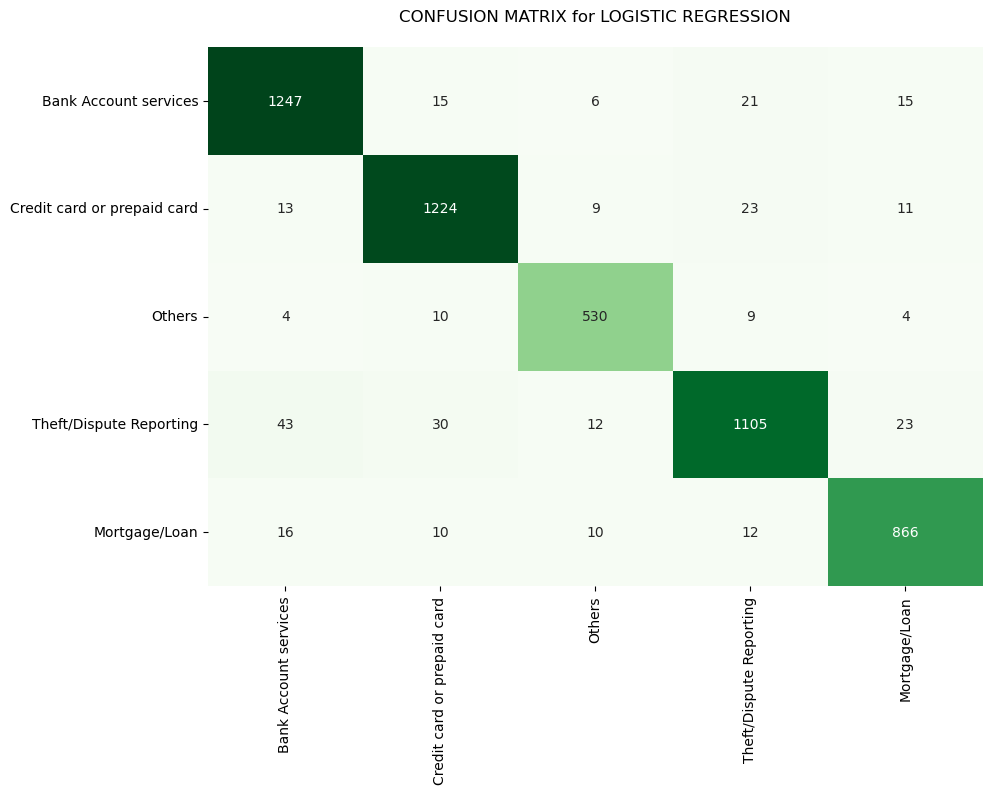

In [137]:
# Evaluate the tuned Logistic Regression classifier
model_eval(y_test, y_pred_lr_tuned, model_name)

In [139]:
# Summary table
summary_table = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score': round(f1_lr, 2)}])
summary_table

,Model,F1 Score
0,Logistic Regression,0.94


##### 6.2 Decision Tree



In [140]:
from sklearn.tree import DecisionTreeClassifier

In [141]:

model_name = 'DECISION TREE'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt =dt.predict(X_test)

In [142]:
# Hyperparameter tuning for best result
param_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [5, 10, 15, 20, 25, 30],
    'min_samples_leaf':[1,5,10,15, 20, 25],
    
}

grid_dt = GridSearchCV(estimator=dt, 
                       param_grid=param_dt,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_dt.fit(X_train, y_train)
print(grid_dt.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'criterion': 'gini', 'max_depth': 25, 'min_samples_leaf': 15}


In [143]:
# Creating model with best hyperparameter
dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=25, 
                                      min_samples_leaf=15, 
                                      )
dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = dt_tuned.predict(X_test)

In [144]:
# Calculate F1 Score of tuned model using weighted average method
f1_dt = f1_score(y_test, y_pred_dt_tuned, average="weighted")
f1_dt

0.7966616303456259

CLASSIFICATION REPORT for DECISION TREE

                             precision    recall  f1-score   support

      Bank Account services       0.79      0.82      0.80      1304
Credit card or prepaid card       0.83      0.82      0.83      1280
                     Others       0.79      0.78      0.78       557
    Theft/Dispute Reporting       0.77      0.73      0.75      1213
              Mortgage/Loan       0.80      0.84      0.82       914

                   accuracy                           0.80      5268
                  macro avg       0.80      0.80      0.80      5268
               weighted avg       0.80      0.80      0.80      5268



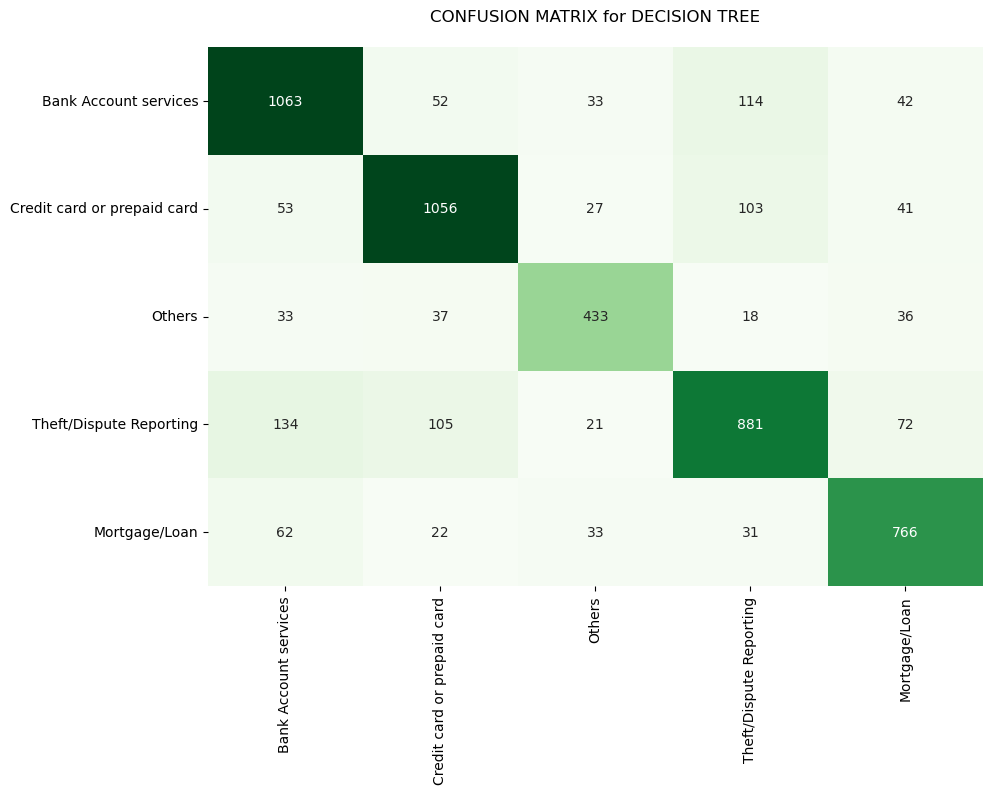

In [145]:
# Evaluate the tuned Decision Tree classifier
model_eval(y_test, y_pred_dt_tuned, model_name)

In [146]:
# Update the summary table
summary_table.loc[len(summary_table.index)] = ['Decision Tree', round(f1_dt, 2)]
summary_table

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80


##### 6.3 Random Forest

In [147]:
from sklearn.ensemble import RandomForestClassifier
model_name = 'RANDOM FOREST'
rf = RandomForestClassifier()

In [148]:
rf.fit(X_train, y_train)

RandomForestClassifier()

In [149]:
# Hyperparameter tuning
param_rf = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth' : [10, 20, 30],
    'min_samples_leaf': [1, 5, 10]
}

grid_rf = GridSearchCV(estimator=rf, 
                       param_grid=param_rf,
                       verbose=1,
                       scoring='f1_weighted',
                       n_jobs=-1,
                       cv=5)
grid_rf.fit(X_train, y_train)

print(grid_rf.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200}


In [150]:
# Create a model with the best hyperparameters
rf_tuned = RandomForestClassifier(n_estimators=100, 
                                   criterion='gini', 
                                   max_depth=20, 
                                   min_samples_leaf=5)
rf_tuned.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, min_samples_leaf=5)

In [151]:
# Make predictions with the tuned model
y_pred_rf_tuned = rf_tuned.predict(X_test)


In [152]:
# Calculate F1 Score of tuned model using weighted average method
f1_rf = f1_score(y_test, y_pred_rf_tuned, average="weighted")
print("F1 Score:", f1_rf)


F1 Score: 0.7307782679729773


CLASSIFICATION REPORT for RANDOM FOREST

                             precision    recall  f1-score   support

      Bank Account services       0.75      0.87      0.81      1304
Credit card or prepaid card       0.68      0.85      0.76      1280
                     Others       0.99      0.13      0.23       557
    Theft/Dispute Reporting       0.78      0.78      0.78      1213
              Mortgage/Loan       0.84      0.81      0.82       914

                   accuracy                           0.76      5268
                  macro avg       0.81      0.69      0.68      5268
               weighted avg       0.78      0.76      0.73      5268



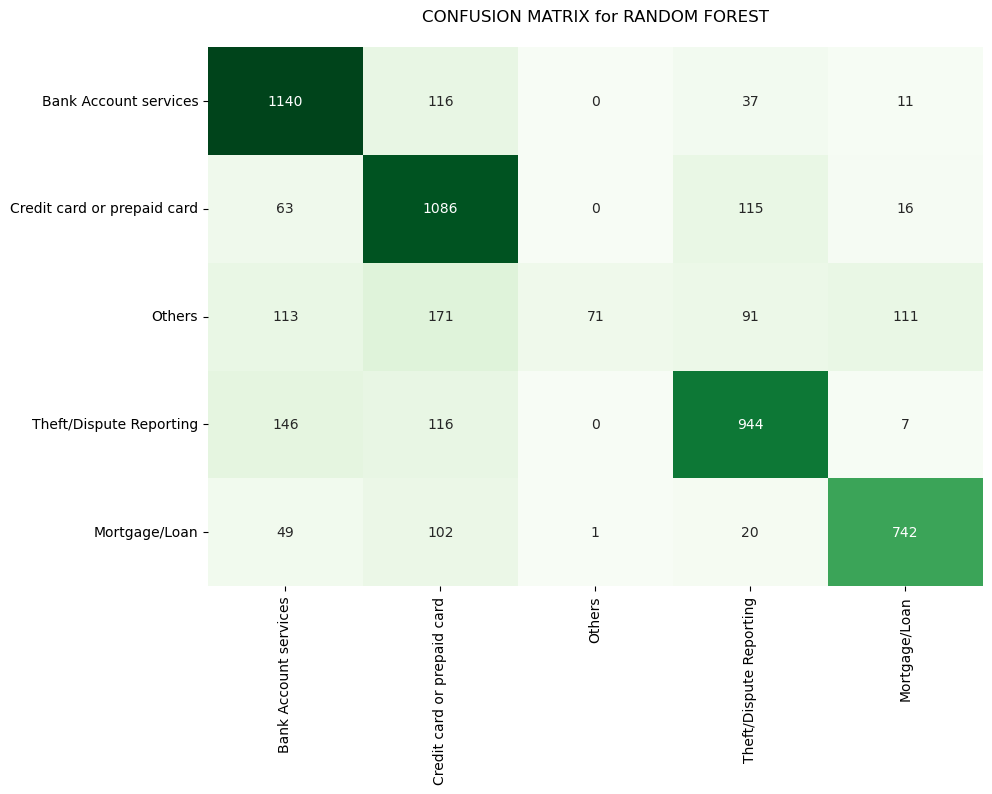

In [153]:
# Evaluate the tuned Random Forest classifier
model_eval(y_test, y_pred_rf_tuned, model_name)

In [154]:
summary_table.loc[len(summary_table.index)] = ['Random Forest', round(f1_rf, 2)]
summary_table

,Model,F1 Score
0,Logistic Regression,0.94
1,Decision Tree,0.80
2,Random Forest,0.73


### Inference:

- Based on the conclusions drawn from the summary table Logistic Regression performs well having 0.94 as the F1 Score

### 7. Using Logistic Regression to predict topics on custom text

In [155]:
# Save Logistic Regression model as pickle file in device
pickle.dump(lr_tuned, open("logreg_model.pkl", "wb"))

In [156]:
# Function to predict a topic for custom text

def topic_predicter(text):
    
    target_names = ["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting", "Mortgage/Loan"]

    load_vec = CountVectorizer(vocabulary=pickle.load(open("count_vector.pkl", "rb")))
    load_tfidf = pickle.load(open("tfidf.pkl","rb"))
    load_model = pickle.load(open("logreg_model.pkl","rb"))

    X_new_count = load_vec.transform(text)
    X_new_tfidf = load_tfidf.transform(X_new_count)
    prediction = load_model.predict(X_new_tfidf)

    return target_names[prediction[0]]

In [157]:
# Create a dataframe of some sample customer complaints
df_custom = pd.DataFrame({'complaints': ["I can not get from chase who services my mortgage, who owns it and who has original loan docs", 
                                  "The bill amount of my credit card was debited twice. Please look into the matter and resolve at the earliest.",
                                  "I want to open a salary account at your downtown branch. Please provide me the procedure.",
                                  "unwanted service activated and money deducted automatically ",
                                  "How can I know my CIBIL score?",
                                  "Where are the bank branches in the city of Patna?"]})
df_custom

,complaints
0,I can not get from chase who services my mortg...
1,The bill amount of my credit card was debited ...
2,I want to open a salary account at your downto...
3,unwanted service activated and money deducted ...
4,How can I know my CIBIL score?
5,Where are the bank branches in the city of Patna?


In [158]:
# Create a new column of predicted topics of each complaint, predicted using the tuned Logistic Regression model
df_custom['predicted topic'] = df_custom['complaints'].apply(lambda x: topic_predicter([x]))
df_custom

,complaints,predicted topic
0,I can not get from chase who services my mortg...,Mortgage/Loan
1,The bill amount of my credit card was debited ...,Credit card or prepaid card
2,I want to open a salary account at your downto...,Bank Account services
3,unwanted service activated and money deducted ...,Bank Account services
4,How can I know my CIBIL score?,Credit card or prepaid card
5,Where are the bank branches in the city of Patna?,Bank Account services


Based on the above analysis on 3 different models, Logistic Regression performs well compared to Random Forest and Decision Tree on predicting the custom data